# Wine quality ANOVA analysis

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

BASE_PATH = "/content/" # Colab
BASE_PATH = "./"        # Local

In [32]:
full_dataset = pd.read_csv(f"{BASE_PATH}wine_data.csv")
full_dataset.info()
feature_colum_names = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
y_column_name = 'Y_qualite'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    6497 non-null   int64  
 1   groupe                6497 non-null   object 
 2   Y_qualite             6497 non-null   int64  
 3    Z_qualite            6497 non-null   object 
 4    couleur              6497 non-null   object 
 5   fixed_acidity         6497 non-null   float64
 6   volatile_acidity      6497 non-null   float64
 7   citric_acid           6497 non-null   float64
 8   residual_sugar        6497 non-null   float64
 9   chlorides             6497 non-null   float64
 10  free_sulfur_dioxide   6497 non-null   float64
 11  total_sulfur_dioxide  6497 non-null   int64  
 12  density               6497 non-null   float64
 13  pH                    6497 non-null   float64
 14  sulphates             6497 non-null   float64
 15  alcohol              

The basic idea behind a one-way ANOVA is to take independent random samples from each group, then compute the sample means for each group. After that compare the variation of sample means among the groups to the variation within the groups. Finally, make a decision based on a test statistic, whether the means of the groups are all equal or not.


**Sum of Squares (SS)**
Inside the One-Way ANOVA Table:
The total amount of variability comes from two possible sources, namely:
1. Difference among the groups, called treatment (TR)
2. Difference within the groups, called error (E)

The sum of the squares due to treatment (SSTR) and the sum of squares due to error (SSE) are listed in the one-way ANOVA table. The sum of SSTR and SSE is equal to the total sum of squares (SSTO).

Just like for SS, d.f. (SSTO) = d.f. (SSTR) + d.f. (SSE)



**Mean Squares (MS)**
A mean square is the sum of squares divided by its d.f. These mean squares are all variances and will be used in the hypothesis test of the equality of all the group population means.

**Assumptions for the one-way ANOVA hypothesis test**
* Sample data are randomly selected from populations and randomly assigned to each of the treatment groups. Each observation is thus independent of any other observation — randomness and independence.
* Normality. Values in each sampled groups are assumed to be drawn from normally distributed populations. We can use normal probability plot or Q-Q plot to check normality.
* Homogeneity of variance. All the c group variances are equal, that is σ₁² = σ₂² = σ₃² = … = σ𝒸². As a rule of thumb, if the ratio of the largest to the smallest sample standard deviation is less than 2, we consider the equal standard deviations assumption as fulfilled.

**The simple outline of the one-way ANOVA test:**
F test for differences in more than two means
H₀: μ₁= μ₂ = μ₃ = … = μ𝒸
H₁: Not all μᵢ’s are equal, where i = 1, 2, 3, …, c.
Level of significance = α



In [6]:
# Split the data
train = full_dataset[full_dataset['groupe'] == 'train']
print(f'Amount of data point in train: {train.shape}')

valid = full_dataset[full_dataset['groupe'] == 'validate']
print(f'Amount of data point in valid: {valid.shape}')

test  = full_dataset[full_dataset['groupe'] == 'test']
print(f'Amount of data point in test : {test.shape}')

Amount of data point in train: (3916, 16)
Amount of data point in valid: (1317, 16)
Amount of data point in test : (1264, 16)


In [86]:
import random

# random sample for 500 wine 
random.seed(30) # set a seed so that everytime we will extract same sample
unique_wine_id = list(train['ID'].unique())
sample_wine_id = random.sample(unique_wine_id, len(train))
sample_df = train[train['ID'].isin(sample_wine_id)].reset_index(drop=True)
metric = "sulphates"
sample_df= sample_df[[y_column_name, metric]]

In [87]:
# two variables of interest
groups = sample_df.groupby(y_column_name).count()
groups

,sulphates
Y_qualite,
3,19
4,117
5,1263
6,1735
7,658
8,120
9,4


**Normality Assumption Check**

Before we perform the hypothesis test, we check if the assumptions for the one-way ANOVA hypothesis test are fulfilled. The samples are random and independent samples. Now, we check the normality assumption by plotting a normal probability plot (Q-Q plots) for each grouped variable


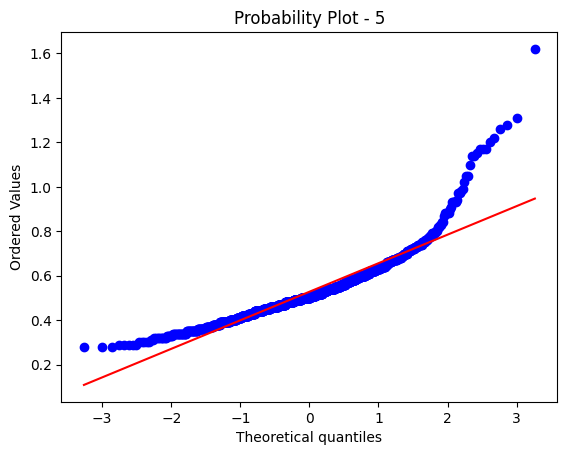

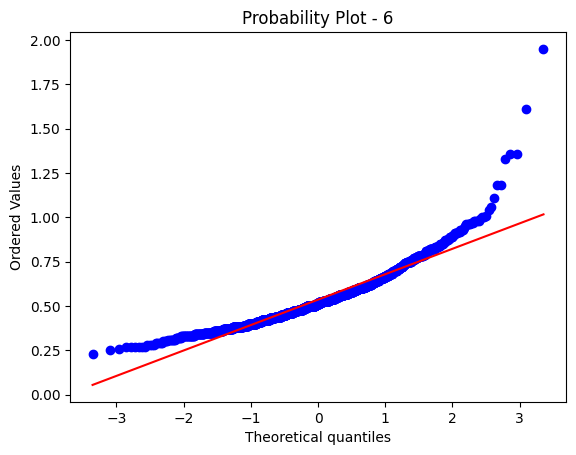

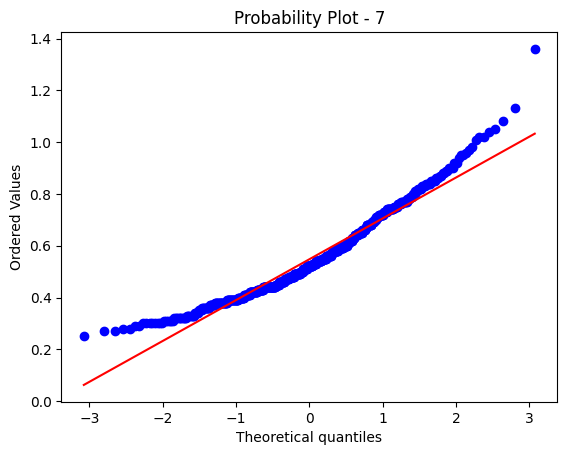

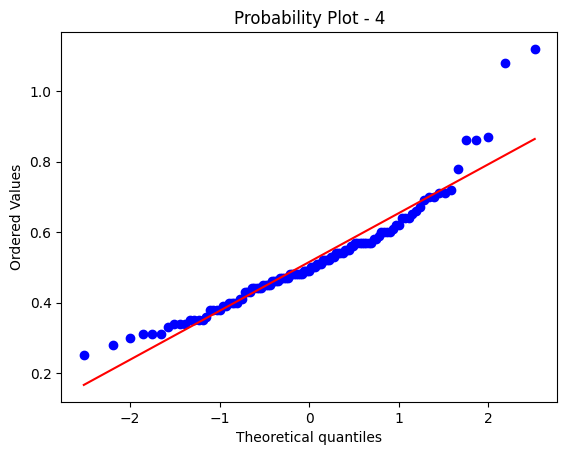

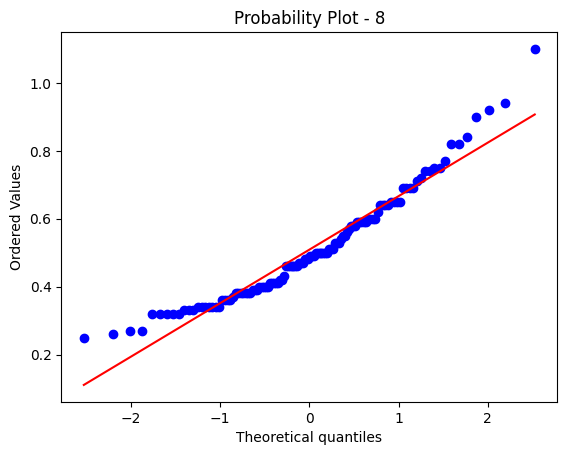

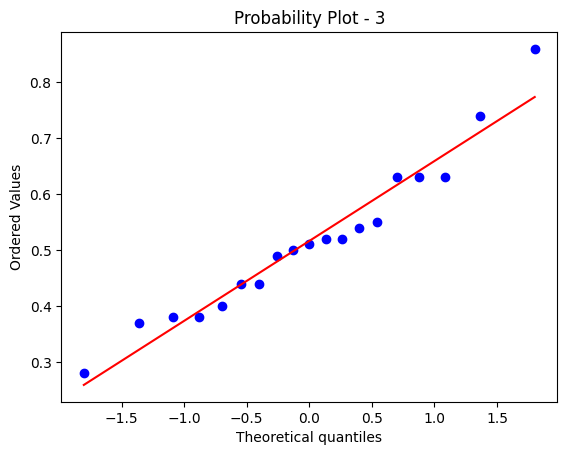

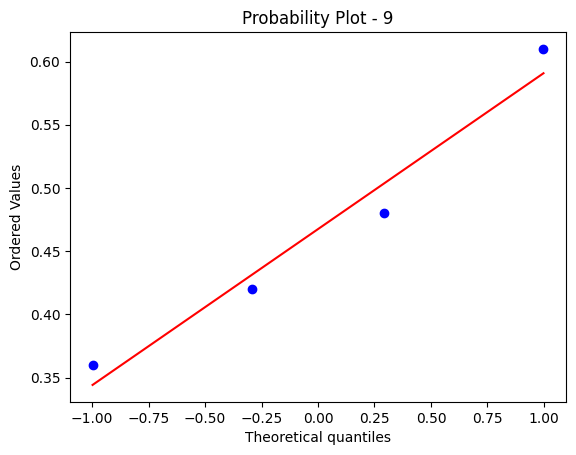

In [88]:
import scipy.stats as stats
import matplotlib.pyplot as plt

qualities = sample_df[y_column_name].unique()
for quality in qualities:
    stats.probplot(sample_df[sample_df[y_column_name] == quality][metric], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  str(quality))
    plt.show()


**Homogeneity of variance Assumption Check**

In [89]:
# calculate ratio of the largest to the smallest sample standard deviation
ratio = sample_df.groupby(y_column_name).std().max() / sample_df.groupby(y_column_name).std().min()
ratio

sulphates    1.509317
dtype: float64

NOT TRUE HERE

The ratio of the largest to the smallest sample standard deviation is 1.67. That is less than the threshold of 2. Thus, we conclude that the assumptions are fulfilled.



**Hypothesis Testing**

According to five steps process of hypothesis testing:

H₀: μ₁= μ₂ = μ₃ = … = μ₆

H₁: Not all quantity of alcohol means are equal

α = 0.05

According to F test statistics:

In [90]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df[metric].mean()
SSTR = sample_df.groupby(y_column_name).count() * (sample_df.groupby(y_column_name).mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR[metric].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby(y_column_name).count() - 1) * sample_df.groupby(y_column_name).std()**2
anova_table['SS']['Within Groups'] = SSE[metric].sum()

# calculate SSTR and update anova table
SSTR = SSTR[metric].sum() + SSE[metric].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df[y_column_name].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df[y_column_name].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,0.313599,6,0.052267,2.378158,0.026962,2.41145
Within Groups,85.910988,3909,0.021978,,,
Total,86.224588,3915,0.022024,,,


In [91]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 2.3781580055749356  and p value is: 0.02696226699446813
Failed to reject the null hypothesis.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 2.3781580055749356  and critical value is: 2.411450162248046
Failed to reject the null hypothesis.
